In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import openpyxl

In [2]:
data=pd.read_excel(r'Load Data in kW.xlsx',engine='openpyxl',names=['data in KW'])

In [3]:
data

,data in KW
0,4983.17184
1,4888.39680
2,5072.95872
3,5196.25980
4,5641.29720
...,...
2178,4626.51840
2179,4567.90752
2180,4723.63164
2181,5150.27520


In [4]:
x=[]
y=[]
for i in range(24,len(data)):
    x.append(data['data in KW'][i-24])
    y.append(data['data in KW'][i])
d={'x':x,'y':y}
data=pd.DataFrame(d)
data

,x,y
0,4983.17184,4775.53968
1,4888.39680,4713.81120
2,5072.95872,4689.02628
3,5196.25980,4844.75040
4,5641.29720,5571.46296
...,...,...
2154,4643.97696,4626.51840
2155,5813.70048,4567.90752
2156,7115.92200,4723.63164
2157,6189.99480,5150.27520


### EDA

In [5]:
data.isnull().sum()

x    0
y    0
dtype: int64

<AxesSubplot:xlabel='x'>

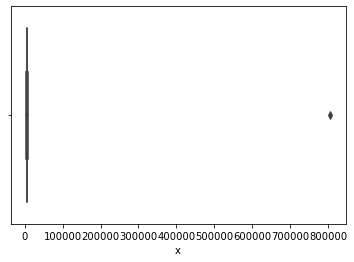

In [6]:
sns.boxplot(data['x'])

<AxesSubplot:xlabel='y'>

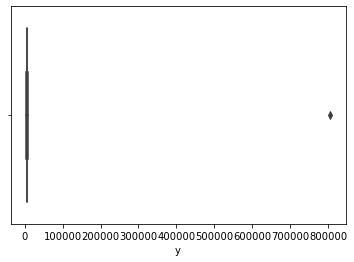

In [7]:
sns.boxplot(data['y'])

<ipython-input-8-d8417b772871>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['z_score_y']=stats.zscore(data['y'])


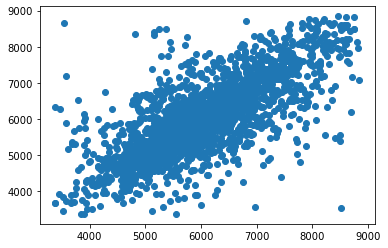

In [8]:
from scipy import stats
data['z_score_x']=stats.zscore(data['x'])
data=data[data['z_score_x'].abs()<=3]


data['z_score_y']=stats.zscore(data['y'])
data=data[data['z_score_y'].abs()<=3]

plt.scatter(data['x'],data['y'])

In [9]:
def normalize(d):
    min_d=min(d)
    max_d=max(d)
    result=[]
    diff=max_d-min_d
    for i in d:
        result.append((i-min_d)/diff)
    return result

In [10]:
x=normalize(data['x'])
y=normalize(data['y'])
l=0.1
r=0.9
E=10**(-8)

### Momentum algorithm

In [11]:
def y_value(m,c,x):
    return m*x+c

In [12]:
def error(y_actual,y_predicted):
    return 0.5*(y_actual-y_predicted)**2

In [13]:
def gradient(m,c,y_actual,x,Gm2,Gc2):
    g_m=(y_actual-m*x-c)*(-1)*x
    g_c=(y_actual-m*x-c)*(-1)
    Gm2=Gm2+(g_m**2)
    Gc2=Gc2+(g_c**2)
    m=m-((l*g_m)/math.sqrt(Gm2+E))
    c=c-((l*g_c)/math.sqrt(Gc2+E))
    return m,c,Gm2,Gc2

In [14]:
def slr(x,y):
    m=0
    c=-1
    Gm2=0
    Gc2=0
    e_list=[]
    for i in range(100):
        for sample in range(len(x)):
            y_predicted=y_value(m,c,x[sample])
            y_actual=y[sample]
            e=error(y_actual,y_predicted)
            m,c,Gm2,Gc2=gradient(m,c,y_actual,x[sample],Gm2,Gc2)
            e_list.append(e)
    return m,c,e_list

### spliting the data

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.10)

### train data model

In [16]:
m_train,c_train,train_e_list=slr(x_train,y_train)

### test model

In [17]:
m_test,c_test,test_e_list=slr(x_test,y_test)

### error metrics

In [18]:
def final_error(m,c):
    mse=0
    mae=0
    for i,j in zip(x,y):
        y_predicted=m*i+c
        y_actual=j
        d=y_actual-y_predicted
        mse+=d*d
        mae+=d
    return 0.5*mae,0.5*mse,math.sqrt(0.5*mse)

#### training error

In [28]:
mae,mse,rmse=final_error(m_train,c_train)

print("MAE of trained data is "+str(mae))
print("MSE of trained data is "+str(mse))
print("RMSE of trained data is "+str(rmse))

MAE of trained data is 0.025179040645292777
MSE of trained data is 18.531921188113728
RMSE of trained data is 4.304871796942823


#### testing error

In [29]:
mae,mse,rmse=final_error(m_test,c_test)

print("MAE of trained data is "+str(mae))
print("MSE of trained data is "+str(mse))
print("RMSE of trained data is "+str(rmse))

MAE of trained data is -13.279466735613987
MSE of trained data is 18.907347353254725
RMSE of trained data is 4.348257967652646


In [30]:
def predict(x):
    min_d=min(data['x'])
    max_d=max(data['y'])
    diff=max_d-min_d
    x=(x-min_d)/diff
    y=m_train*x+c_train
    y=(y*(max(data['x'])-min(data['y'])))+min(data['y'])
    return y

In [31]:
predict(4000)

4529.087876523644

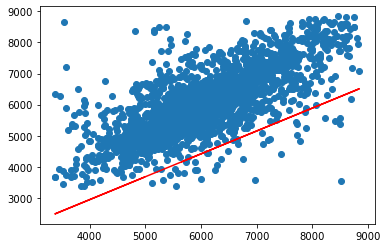

In [32]:
plt.scatter(data['x'],data['y'])
plt.plot(data['x'],m_train*data['x']+c_train,color='red')